# Protocol Benchmarks

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from functools import *
from glob import glob as list_files
from pathlib import Path

In [2]:
try:
    files = list_files(os.environ['BENCH_RESULTS_DIR'] + '/*/*.csv')
except:
    files = list_files("../benchmark-results/*/*/*.csv")
dfs = []
for file in files:
    runId = Path(file).name
    system = Path(file).parent.parent.name
    df = pd.read_csv(file, delimiter=";", dtype={'latency': 'float64', 'send-time': 'float64', 'receive-time': 'float64'})

    params = runId.split('-')
    
    df["run_config"] = f"{params[0]} {params[1]} {params[2]} {params[3]}"
    df["run_id"] = params[4]
    df["run"] = runId
    df["system"] = system
    df["index"] = pd.Series(range(0, len(df)))
    df['receive-time'] = df['receive-time'] - df['send-time'].min()
    df['send-time'] = df['send-time'] - df['send-time'].min()
    dfs.append(df)

df = pd.concat(dfs)
df["latency"] = (df["latency"] / 1000)
df['send-time'] = df['send-time'] / 1000
df['receive-time'] = df['receive-time'] / 1000
df["unit"] = "ms" # fix unit

df

,name,op,args,send-time,receive-time,latency,unit,run_config,run_id,run,system,index
0,client1,put,client1-key value,0.000,0.138,0.138140,ms,client1 cluster3 put 10_30,run1.csv,client1-cluster3-put-10_30-run1.csv,pb,0
1,client1,put,client1-key value,4.003,4.177,0.174128,ms,client1 cluster3 put 10_30,run1.csv,client1-cluster3-put-10_30-run1.csv,pb,1
2,client1,put,client1-key value,4.252,4.392,0.139633,ms,client1 cluster3 put 10_30,run1.csv,client1-cluster3-put-10_30-run1.csv,pb,2
3,client1,put,client1-key value,4.421,4.570,0.148960,ms,client1 cluster3 put 10_30,run1.csv,client1-cluster3-put-10_30-run1.csv,pb,3
4,client1,put,client1-key value,4.601,4.789,0.187843,ms,client1 cluster3 put 10_30,run1.csv,client1-cluster3-put-10_30-run1.csv,pb,4
...,...,...,...,...,...,...,...,...,...,...,...,...
140995,client1,put,client1-key value,30064.923,30065.087,0.163538,ms,client1 cluster3 put 10_30,run5.csv,client1-cluster3-put-10_30-run5.csv,pb-new,140995
140996,client1,put,client1-key value,30065.087,30065.244,0.156845,ms,client1 cluster3 put 10_30,run5.csv,client1-cluster3-put-10_30-run5.csv,pb-new,140996
140997,client1,put,client1-key value,30065.244,30065.411,0.167395,ms,client1 cluster3 put 10_30,run5.csv,client1-cluster3-put-10_30-run5.csv,pb-new,140997
140998,client1,put,client1-key value,30065.412,30065.578,0.166844,ms,client1 cluster3 put 10_30,run5.csv,client1-cluster3-put-10_30-run5.csv,pb-new,140998


In [3]:
latency_df = df[['system', 'run_config', 'latency', 'index', 'name']] \
    .groupby(['system', 'run_config', 'index', 'name']) \
    .mean().reset_index().set_index('index')

pb
client1 cluster3 put 10_30
client1 cluster3 put 10_30_k3a15
pb-new
client1 cluster3 put 10_30
client1 cluster3 put 10_30_k3a15


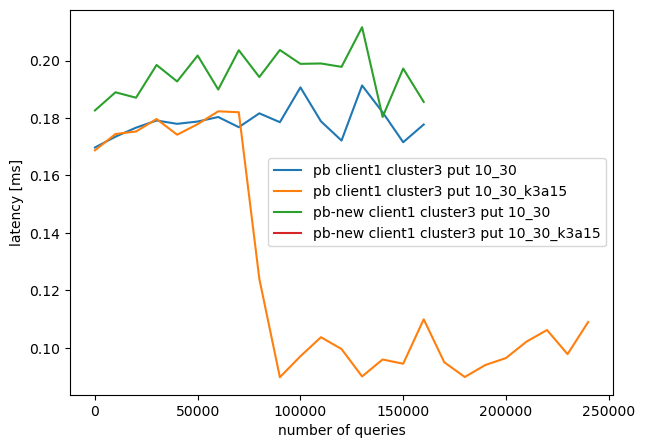

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(7,5))

def plot_latency(ax, label: str, df: pd.DataFrame, group_size):
    grouped_df = df.groupby({x: (x // group_size) * group_size for x in range(len(df))})
    mean_latency = grouped_df.mean()
    
    mean_latency.plot(y='latency', ax=ax, label=label)
    


for system in latency_df['system'].unique():
    print(system)
    system_df = latency_df[latency_df['system'] == system]
    
    for run_config in latency_df['run_config'].unique():
        print(run_config)
        run_df = system_df[system_df['run_config'] == run_config]
            
        plot_latency(ax, f"{system} {run_config}", run_df[['latency']], 10000)

ax.set_xlabel("number of queries")
ax.set_ylabel("latency [ms]")

# ax.set_ylim([0,None])

ax.legend()

# plt.savefig(fname="latency.pdf", format="pdf")

In [5]:
df["seconds"] = (df["receive-time"] / 1000).apply(round)

Mean Throughput for pb client1 cluster3 put 10_30: 5599.2
Mean Throughput for pb client1 cluster3 put 10_30_k3a15: 5911.8
Mean Throughput for pb-new client1 cluster3 put 10_30: 5078.2


Text(0, 0.5, 'throughput [ops/s]')

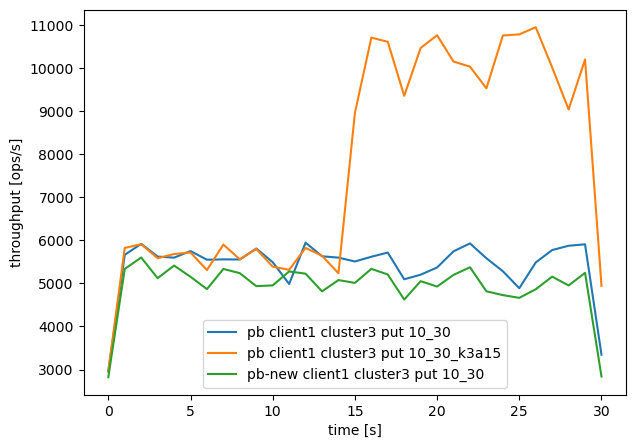

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(7,5))

res_data = []

for system in df['system'].unique():
    sys_df = df[df['system'] == system]
    
    for run_id in sys_df["run_config"].unique():
        filtered_df = sys_df[(sys_df["run_config"] == run_id)]
        
        throughput = filtered_df.groupby("seconds")["name"].count() / len(sys_df[sys_df['run_config'] == run_id]['run_id'].unique())
        throughput.plot(ax=ax, label=f"{system} {run_id}")
        mean_throughput = throughput.quantile(0.5)
        res_data.append([system, run_id.split(" ")[1], mean_throughput])
        print(f"Mean Throughput for {system} {run_id}: {mean_throughput}")
    
        # also_mean_throughput = filtered_df["name"].count() / filtered_df["seconds"].max()
        # print(f"Diff {mean_throughput - also_mean_throughput}")
        
        #ax.axhline(y=mean_throughput, color=ax.get_lines()[-1].get_color())
        # ax.axhline(y=also_mean_throughput, color=ax.get_lines()[-1].get_color())

ax.legend()

ax.set_xlabel('time [s]')
ax.set_ylabel('throughput [ops/s]')

# plt.savefig(fname="throughput.pdf", format="pdf")

ValueError: All arrays must be of the same length

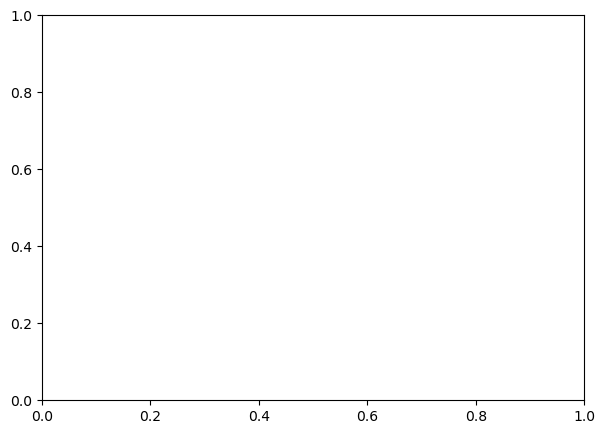

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(7,5))

res_df = pd.DataFrame(data=res_data, columns=['system', 'type', 'throughput'])

etcd_df = res_df[res_df.system == 'etcd'][['type', 'throughput']]
pb_df = res_df[res_df.system == 'pb'][['type', 'throughput']]

pd.DataFrame(data={'type': etcd_df.type, 'etcd': list(etcd_df.throughput), 'pb': list(pb_df.throughput)}).set_index('type').plot.bar(ax=ax)

ax.set_ylabel('throughput [ops/s]')
ax.set_xlabel('')

# fig.savefig(fname="throughput_comp.pdf", format="pdf")

In [ ]:
df.groupby(['system', 'run_config', 'run_id'])['send-time'].max() / 1000